<a href="https://colab.research.google.com/github/mezaga/ACIML/blob/aciml-06%2F10%2F22/ACIML_seminario_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ACIML**

In [ ]:
#@title Carga de Librerias

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jUsI1u3bDkgVyIEuVXaxjEMp_VeEKQvc' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jUsI1u3bDkgVyIEuVXaxjEMp_VeEKQvc" -O encoder2.zip && rm -rf /tmp/cookies.txt
!unzip /content/encoder2.zip
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ju7FwlpdeuROeRFjyq34I8UAp6aVwsY6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ju7FwlpdeuROeRFjyq34I8UAp6aVwsY6" -O decoder2.zip && rm -rf /tmp/cookies.txt
!unzip /content/decoder2.zip
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import random
AUDIO_LOAD = []
etiquetas = []
track_num = []

# En la siguente celda puedes subir tus archivos.
1. Escoge el nombre del grupo de audios.
2. Evalúa la celda.
3. Repite hasta tener todos los conjuntos que necesites

In [ ]:
#@title Carga de archivos
## 

from google.colab import files
#@ tectInserta
text = 'am' #@param {type:"string"}
#AUDIO_LOAD = []
sr16k = 16000
secs = 1
uploaded = files.upload()
track_num.append(len(uploaded))
for idx, track in enumerate(uploaded.keys()):
  print(track)
  if track.endswith("wav"):
      SR = librosa.get_samplerate(track)
      y, fs = librosa.load(track, SR)
      data = librosa.resample(y[:SR * secs], orig_sr= SR, target_sr= sr16k)
      ##features (tenemos que arreglar el fft apara que sean valores de amp)
      fft = librosa.amplitude_to_db(np.abs(np.fft.fft(data)))
      f0 = np.mean(librosa.yin(data, 30, 2093, sr= sr16k, frame_length= 2048, win_length= 1024))
    #takes only 1 sec and resample to 16k 
      etiquetas.append(text)
      AUDIO_LOAD.append({'gid': text,'id': text+ str(idx), 'trackname': track, 'data': data, 'fft': fft, 'f0': f0})
      

Saving am_0.wav to am_0.wav
Saving am_1.wav to am_1.wav
Saving am_2.wav to am_2.wav
Saving am_3.wav to am_3.wav
Saving am_4.wav to am_4.wav
Saving am_5.wav to am_5.wav
Saving am_6.wav to am_6.wav
Saving am_7.wav to am_7.wav
Saving am_8.wav to am_8.wav
Saving am_9.wav to am_9.wav
Saving am_10.wav to am_10.wav
Saving am_11.wav to am_11.wav
Saving am_12.wav to am_12.wav
Saving am_13.wav to am_13.wav
Saving am_14.wav to am_14.wav
Saving am_15.wav to am_15.wav
Saving am_16.wav to am_16.wav
Saving am_17.wav to am_17.wav
Saving am_18.wav to am_18.wav
Saving am_19.wav to am_19.wav
Saving am_20.wav to am_20.wav
Saving am_21.wav to am_21.wav
Saving am_22.wav to am_22.wav
Saving am_23.wav to am_23.wav
Saving am_24.wav to am_24.wav
Saving am_25.wav to am_25.wav
Saving am_26.wav to am_26.wav
Saving am_27.wav to am_27.wav
Saving am_28.wav to am_28.wav
Saving am_29.wav to am_29.wav
Saving am_30.wav to am_30.wav
Saving am_31.wav to am_31.wav
Saving am_32.wav to am_32.wav
Saving am_33.wav to am_33.wav


En la siguiente celda podrás visualizar una tabla con múltiples características que los describen

In [ ]:
#@title DATASET

DATA = pd.DataFrame(AUDIO_LOAD)
#PCA 
data_fft = np.vstack(DATA['fft'])
mu_fft = np.mean(data_fft, axis= 0)
s_fft = np.std(data_fft, axis = 0)+ 0.000001
Xmu_FFT = data_fft- mu_fft/s_fft
DATA

,gid,id,trackname,data,fft,f0
0,fm,fm0,fm_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.454912725677432, -8.373184263866577, -6.10...",81.960707
1,fm,fm1,fm_1.wav,"[0.025129607, 0.043615725, 0.04222123, 0.04870...","[2.218131057360571, 3.4567507357789706, 4.5381...",189.012737
2,fm,fm2,fm_2.wav,"[4.924257e-05, -0.00019987492, -0.00015007818,...","[-51.46414685757855, -29.752441595836927, -40....",2233.535982
3,fm,fm3,fm_3.wav,"[0.028035654, 0.044978045, 0.03788065, 0.04021...","[1.8492719266670963, 1.801512028309491, 1.8270...",87.675389
4,fm,fm4,fm_4.wav,"[-0.009997554, -0.017094012, -0.015903568, -0....","[-8.31961211850192, 0.41499022007324704, -2.53...",185.483917
...,...,...,...,...,...,...
251,am,am123,am_123.wav,"[0.006183336, 0.00027287987, -0.0010259093, 0....","[-45.587047052632585, -43.612486156823145, -44...",324.796241
252,am,am124,am_124.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-58.85326489347548, -57.82030591045736, -57.4...",154.919166
253,am,am125,am_125.wav,"[0.0077198083, -1.113632e-07, -0.00084601715, ...","[-43.593185861663464, -42.48458194909128, -42....",625.317237
254,am,am126,am_126.wav,"[0.0010523294, -0.00037933944, 0.0001747532, -...","[-52.7273168580075, -52.7273168580075, -52.727...",1017.710764


In [ ]:
#@title Filtrado
zliders = dict(DATA['gid'].value_counts())
color = list(np.random.choice(np.random.randint(0,30),len(zliders),replace = False))
sliders = []
for key in zliders.keys():
  sliders.append(widgets.IntSlider(value = zliders[key], max= zliders[key], step = 1, description= key))

update_sliders = dict(zip([x for x in zliders], sliders))

ui = widgets.VBox(sliders)

def datafilter(**kwargs):
  '''update n number of sliders corresponding to dataclases by splitting dataset uin subgroups and joining them again'''
  dframes = []
  for key, value in kwargs.items():
    dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value])
    #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
  print(DATA_filt['gid'])
  return DATA_filt


out = widgets.interactive_output(datafilter, update_sliders)
updated_df = datafilter
display(ui,out)

Output()

In [ ]:
#@title DATASET
dframes = []
for key, value in update_sliders.items():
  dframes.append(DATA[DATA['gid'] == key].reset_index().iloc[0: value.value])
  #print(key + str(value))
  DATA_filt = pd.concat(dframes).reset_index()
audiotracks = dict(zip(DATA_filt['id'],DATA_filt['id'].index))
DATA_filt

,level_0,index,gid,id,trackname,data,fft,f0
0,0,0,fm,fm0,fm_0.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.454912725677432, -8.373184263866577, -6.10...",81.960707
1,1,1,fm,fm1,fm_1.wav,"[0.025129607, 0.043615725, 0.04222123, 0.04870...","[2.218131057360571, 3.4567507357789706, 4.5381...",189.012737
2,2,2,fm,fm2,fm_2.wav,"[4.924257e-05, -0.00019987492, -0.00015007818,...","[-51.46414685757855, -29.752441595836927, -40....",2233.535982
3,3,3,fm,fm3,fm_3.wav,"[0.028035654, 0.044978045, 0.03788065, 0.04021...","[1.8492719266670963, 1.801512028309491, 1.8270...",87.675389
4,4,4,fm,fm4,fm_4.wav,"[-0.009997554, -0.017094012, -0.015903568, -0....","[-8.31961211850192, 0.41499022007324704, -2.53...",185.483917
...,...,...,...,...,...,...,...,...
251,123,251,am,am123,am_123.wav,"[0.006183336, 0.00027287987, -0.0010259093, 0....","[-45.587047052632585, -43.612486156823145, -44...",324.796241
252,124,252,am,am124,am_124.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-58.85326489347548, -57.82030591045736, -57.4...",154.919166
253,125,253,am,am125,am_125.wav,"[0.0077198083, -1.113632e-07, -0.00084601715, ...","[-43.593185861663464, -42.48458194909128, -42....",625.317237
254,126,254,am,am126,am_126.wav,"[0.0010523294, -0.00037933944, 0.0001747532, -...","[-52.7273168580075, -52.7273168580075, -52.727...",1017.710764


variance: 
[0.59669367 0.09732712]


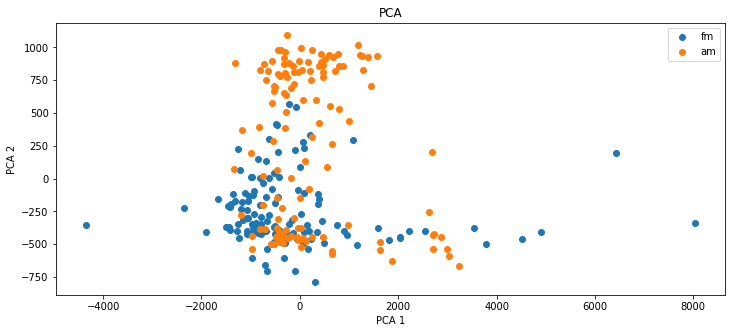

In [ ]:
#@title Visualización de datos { run: "auto" }
ids = list(DATA_filt['id'])
audio_viz = 'PCA' #@param ['PCA','F0', 'histogram']
fig, ax = plt.subplots()
fig.set_size_inches([12,5])
if audio_viz == 'histogram':
  ax = DATA_filt['gid'].hist()
  ax.set_xlabel("Synth type")
  ax.set_ylabel(" # of observations")
  plt.show()
if audio_viz == 'F0':
  ax.plot(DATA_filt.index, DATA_filt['f0'], linestyle = '--')
  ax.set_xlabel("Audios")
  ax.set_ylabel(" F0")
  plt.show()
if audio_viz == 'PCA':
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(Xmu_FFT)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0
  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  #for idx, id in enumerate(ids):
  #  ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  fig.add_axes(ax)
  plt.legend()
  plt.title('PCA')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.show()
  


In [ ]:
#@title Entrenamiento del modelo

from google.colab import files
##standarizacion de datos
data = np.vstack(DATA_filt['data'])
mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]
Xw = (data- mu_wave)/max_wave
Xw = Xw[...,np.newaxis][...,np.newaxis]

referencia_1 = 'Preentrenado' #@param ['Nuevo modelo','Preentrenado','mi modelo']
Epocas = 10 #@param {type:"slider", min:10, max:10000, step:1}

batches = 20 #@param {type: "integer"}
lr = 0.00008 #@param {type: "slider", min:0.00001, max: 0.0001, step:0.00001}
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
if referencia_1 == 'Preentrenado': 
  original_dim = (16000, 1, 1)
  encoder_inputs = keras.Input(original_dim)  
  encoder_pretrained = tf.keras.models.load_model('/content/encoder2',compile = False)
  decoder_pretrained = tf.keras.models.load_model('/content/decoder2',compile = False)
  outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
  vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
  vae.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  latent =  encoder_pretrained.predict(Xw[0:])

if referencia_1 == 'Nuevo modelo': 
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
else:
  print('.....')
  '''
  new_model = tf.keras.models.load_model('/content/model_vae')
  new_model.compile(optimizer= optimizer,loss = 'mean_squared_error')
  tr_logs = new_model.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)
  '''


Epoch 1/10
13/13 [==============================] - 10s 123ms/step - loss: 0.0161
Epoch 2/10
13/13 [==============================] - 1s 97ms/step - loss: 0.0156
Epoch 3/10
13/13 [==============================] - 1s 97ms/step - loss: 0.0154
Epoch 4/10
13/13 [==============================] - 1s 97ms/step - loss: 0.0153
Epoch 5/10
13/13 [==============================] - 1s 97ms/step - loss: 0.0152
Epoch 6/10
13/13 [==============================] - 1s 97ms/step - loss: 0.0151
Epoch 7/10
13/13 [==============================] - 1s 97ms/step - loss: 0.0151
Epoch 8/10
13/13 [==============================] - 1s 98ms/step - loss: 0.0150
Epoch 9/10
13/13 [==============================] - 1s 98ms/step - loss: 0.0150
Epoch 10/10
8/8 [==============================] - 1s 19ms/step
.....


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


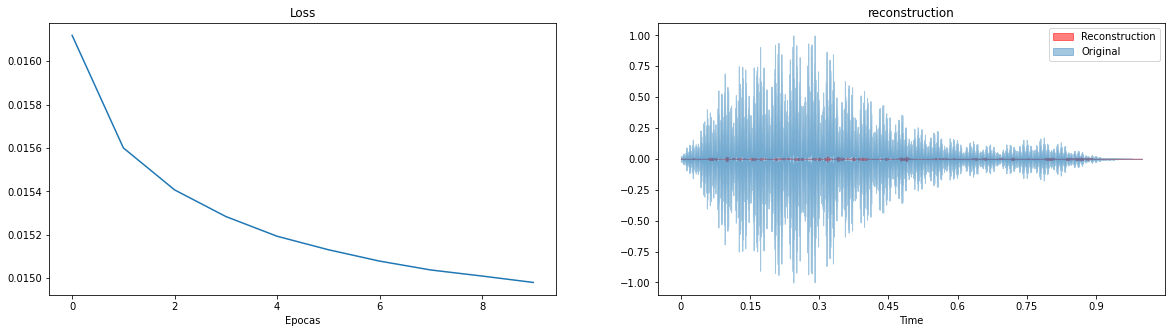

In [ ]:
#@title Evaluación del modelo
#una visualización donde se vea la curva del modelo junto a la recunstruccion

def latent_vectorize(audio_id,df,audio_list):
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  return latent_gen[0]

def latent_reconstruction(latent_gen):
  recons = decoder_pretrained.predict(latent_gen[0:])
  recons= recons[0].flatten()
  return recons


def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  try:
    latent_gen = latent_vectorize(audio_id,df,audio_list)
    recons = latent_reconstruction(latent_gen)
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
    
def latent_inter(audio_a, audio_b, step = 100, porcentaje = 50, audio_list = Xw):
  'crea 100 vectores pensados en % y reconstruye'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  else:
    listas = np.linspace(audio_a, audio_b, step)
    res = latent_reconstruction(listas[porcentaje-1:])
  return res

'''
def latent_search(audio_id, df, audio_list):
 ''''''function that retrieves the correct audio representation in the latent space''''''
  try:
    audio_idx = list(df[df['id'] == audio_id].index)[0]
    latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
    recons = decoder_pretrained.predict(latent_gen[0][0:])
    recons= recons[0].flatten()
    return latent_gen, recons
  except TypeError:
    print("audio input must be a valid string")
'''

def gps_latent(dic_tracks, df, data):
  '''search all track ids position in the latent space in an ''orderly fashion'' '''
  res_latent = []
  for key in dic_tracks.keys():
    res_latent.append(latent_search(key, df, data)[0])
  return res_latent

all_tracks_latent = gps_latent(audiotracks, DATA_filt, Xw)



track = random.choices(ids)[0]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].plot(tr_logs.history['loss'])
librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')
ax[1].legend()
ax[0].set_xlabel("Epocas")
ax[0].set_title('Loss')
ax[1].set_title('reconstruction')


####archivos de audio
IPython.display.display(IPython.display.Audio(Xw[audiotracks[track]].flatten(), rate = sr16k))
IPython.display.display(IPython.display.Audio(latent_search(track, DATA_filt, Xw)[1],rate = sr16k))

1/1 [==============================] - 0s 16ms/step


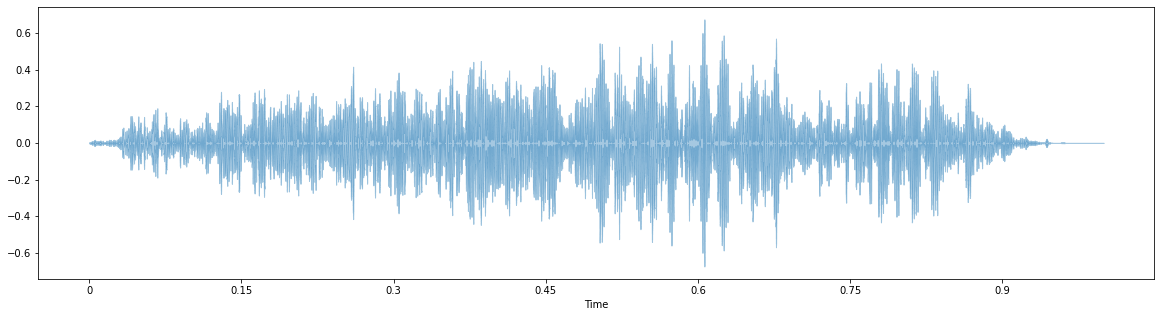

In [ ]:
#@title Interpolación { run: "auto" }
audio = 'am60' #@param {type:"string"}
audio2 = 'fm60' #@param {type:"string"}

porcentaje_de_cambio = 4 #@param {type:"slider", min:1, max:10, step:1}
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

idx = list(DATA_filt[DATA_filt['id'] == audio].index)[0]
idx2 = list(DATA_filt[DATA_filt['id'] == audio2].index)[0]
audio_a = all_tracks_latent[0][idx]
audio_b = all_tracks_latent[0][idx2]
inter = latent_inter(audio_a, audio_b, 10, porcentaje_de_cambio)

#a_1 = latent_search(audio)[0]
#a_2 = latent_search(audio)[0]

#inter = latent_inter(a_1,a_2, 100, porcentaje_de_cambio)
#ax.plot(inter)
librosa.display.waveshow(inter, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(inter, rate = sr16k))



******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

******
*
*
*
*
*
*
*
*
*
*
*
*




******

1/1 [==============================] - 0s 158ms/step


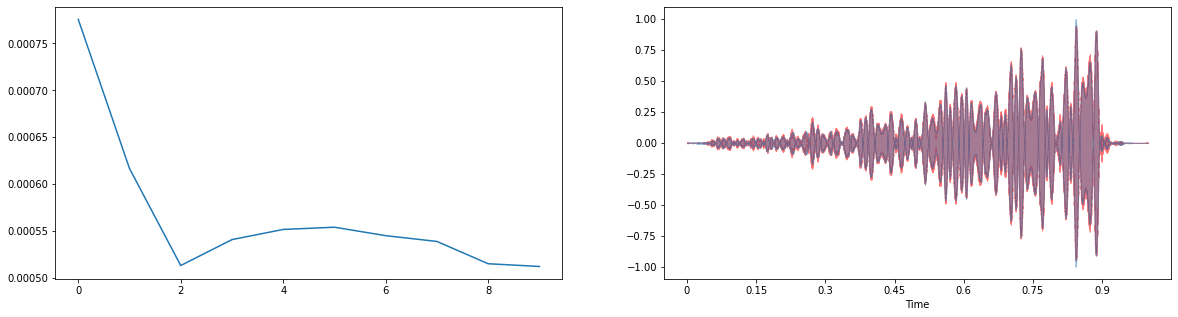

In [ ]:
from ipywidgets import Button, HBox, VBox
#@title Generación de Audios
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)

tecnicas = 'Interpolacion_lineal' #@param ['Interpolacion_lineal']

def latent_inter(audio_a, audio_b, step = 100, porcentaje = 50):
  'step hace referencia al numero de audios entre las referencias'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step)#.flatten()
  else:
    listas = np.linspace(audio_a, audio_b, step)
  return listas[porcentaje- 1]

if tecnicas == 'Interpolacion_lineal':
  left_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 1:',
    disabled=False,
)
  right_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 2:',
    disabled=False,
)
  ax[0].plot(tr_logs.history['loss'])
  librosa.display.waveshow(latent_search(track, DATA_filt, Xw)[1], sr=16000, color='r', alpha=0.5, ax=ax[1], label='Reconstruction')
  librosa.display.waveshow(Xw[audiotracks[track]].flatten(), sr=16000, alpha=0.4, ax=ax[1], label='Original')




if tecnicas == 'Vecinos euclidaneos':
  left_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 1:',
    disabled=False,
)
  right_box = widgets.Dropdown(options= list(DATA_filt['id']),description='track ref. 2:',
    disabled=False,
)
  right_box = widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)
  



if tecnicas == 'random_walk':
  left_box= widgets.HTML(
    value="Hello <b>World</b>",
    placeholder='Some HTML',
    description='Some HTML',
)
  right_box = widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)   
HBox([left_box, right_box])

In [ ]:
latent_inter([1,2,3],[2,3,4],100, 10)

array([2., 3., 4.])

In [ ]:
def latent_search(audio_id, df, audio_list):
  '''function that retrieves the correct audio representation in the latent space'''
  audio_idx = list(df[df['id'] == audio_id].index)[0]
  latent_gen = encoder_pretrained.predict(audio_list[audio_idx:])
  recons = decoder_pretrained.predict(latent_gen[0][0:])
  recons= recons[0].flatten()
  return latent_gen[0], recons 

In [ ]:
len(all_tracks_latent)
all_tracks_latent[0]

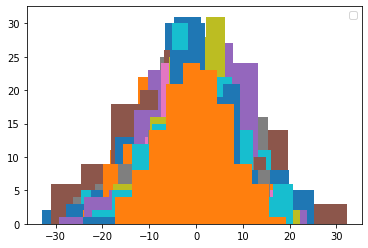

In [ ]:
fig, ax = plt.subplots()
for z in all_tracks_latent[0:]:
    #print(key,value)
    ax.hist(z[0][0],linestyle= '--')

ax.legend()

1/1 [==============================] - 0s 88ms/step


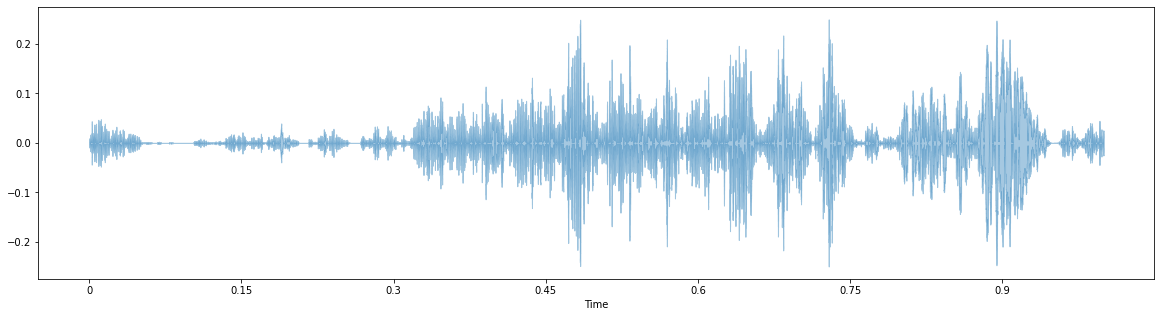

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)
audio_random = np.random.normal(0,10, size= (2,128))
recons = decoder_pretrained.predict(audio_random)
recons= recons[0].flatten()
librosa.display.waveshow(recons, sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(recons, rate = sr16k))


In [ ]:
audio_random = np.random.normal(0,20, size= 128)
audio_random.shape

(128,)

In [ ]:
fig, ax = plt.subplots()
for z in all_tracks_latent[0:]:
    #print(key,value)
    ax.hist(z[0][0],linestyle= '--')

ax.legend()

In [ ]:
a = all_tracks_latent[0][0][7].sum()
a

-144.35236

In [ ]:
stats = pd.DataFrame(all_tracks_latent[0][0])
stats

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-14.795782,-11.947716,8.047822,9.558630,-1.853710,0.889804,-2.231610,-23.044830,4.590186,-12.021617,...,-2.302913,-10.349595,3.349956,21.386347,-4.348809,-10.840456,-0.045677,-15.014729,-6.442639,-8.524030
1,-7.226787,4.367860,12.853249,-25.384727,-1.668204,4.298459,-14.701450,1.886290,-2.100385,3.053360,...,10.318612,0.173237,-0.335024,6.165597,-16.440369,11.370034,10.248044,-8.995099,0.768094,-14.473238
2,-2.505748,-5.219619,-12.280242,-3.395528,13.362095,-5.590985,-2.772105,6.620042,2.188305,1.804336,...,-4.409658,-1.451336,2.997745,15.281128,-0.875841,5.621507,7.873076,-7.188708,4.559099,8.828068
3,-4.386611,2.115524,4.459554,6.331384,-12.271301,4.308730,-0.152749,-2.893622,-1.071448,10.551438,...,7.231719,9.340551,1.018890,-0.672186,8.283608,1.755874,0.388554,-0.093345,-0.789249,4.020247
4,-0.877882,-1.339418,-0.250670,4.854614,-9.407674,-1.230035,-3.991618,-14.641028,-0.910868,12.963414,...,16.174953,-2.822707,-9.223618,11.202159,4.943830,4.240277,-2.307746,-3.685283,-7.982797,-6.027159
5,-29.592857,-15.858122,7.868086,3.219487,-8.890918,13.586840,-5.859944,-7.125887,-3.545021,-24.177004,...,-10.963478,12.688472,1.790102,-4.452397,12.401487,-13.175158,15.945800,-13.829837,-11.912501,19.490715
6,-14.021227,-3.258181,-4.357509,8.880535,-1.387083,-0.761708,-3.333032,-10.780828,7.140913,-3.666169,...,0.193616,11.104348,-6.564552,1.504889,8.498902,-1.379543,8.148353,3.704531,-9.805351,16.876696
7,-6.350094,-9.760777,18.506094,6.576551,-3.697433,-3.378847,-6.993721,11.577950,2.164591,-9.146664,...,-7.721735,12.517977,-4.573471,4.072114,-12.491581,-1.138168,5.472628,-10.253342,-4.377699,2.527116
8,0.443083,-2.664476,-7.623561,0.570617,9.924716,-10.312866,-2.846198,5.144423,1.727444,8.069558,...,-8.366299,-4.981899,5.482423,9.493663,0.044380,0.469336,7.173205,-5.420767,8.575545,1.788113
9,-0.602849,-0.323343,2.970940,8.636977,-9.047282,7.315296,-7.419866,-14.300456,3.425889,13.865311,...,17.173241,-2.718408,-15.748876,8.231772,13.926442,-4.402750,-5.762714,3.075157,2.677382,-1.653022


In [ ]:
stats['ids'] = DATA_filt['id']
stats.set_index('ids')

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
ids,,,,,,,,,,,,,,,,,,,,,
fm0,-14.795782,-11.947716,8.047822,9.558630,-1.853710,0.889804,-2.231610,-23.044830,4.590186,-12.021617,...,-2.302913,-10.349595,3.349956,21.386347,-4.348809,-10.840456,-0.045677,-15.014729,-6.442639,-8.524030
fm1,-7.226787,4.367860,12.853249,-25.384727,-1.668204,4.298459,-14.701450,1.886290,-2.100385,3.053360,...,10.318612,0.173237,-0.335024,6.165597,-16.440369,11.370034,10.248044,-8.995099,0.768094,-14.473238
fm2,-2.505748,-5.219619,-12.280242,-3.395528,13.362095,-5.590985,-2.772105,6.620042,2.188305,1.804336,...,-4.409658,-1.451336,2.997745,15.281128,-0.875841,5.621507,7.873076,-7.188708,4.559099,8.828068
fm3,-4.386611,2.115524,4.459554,6.331384,-12.271301,4.308730,-0.152749,-2.893622,-1.071448,10.551438,...,7.231719,9.340551,1.018890,-0.672186,8.283608,1.755874,0.388554,-0.093345,-0.789249,4.020247
fm4,-0.877882,-1.339418,-0.250670,4.854614,-9.407674,-1.230035,-3.991618,-14.641028,-0.910868,12.963414,...,16.174953,-2.822707,-9.223618,11.202159,4.943830,4.240277,-2.307746,-3.685283,-7.982797,-6.027159
fm5,-29.592857,-15.858122,7.868086,3.219487,-8.890918,13.586840,-5.859944,-7.125887,-3.545021,-24.177004,...,-10.963478,12.688472,1.790102,-4.452397,12.401487,-13.175158,15.945800,-13.829837,-11.912501,19.490715
fm6,-14.021227,-3.258181,-4.357509,8.880535,-1.387083,-0.761708,-3.333032,-10.780828,7.140913,-3.666169,...,0.193616,11.104348,-6.564552,1.504889,8.498902,-1.379543,8.148353,3.704531,-9.805351,16.876696
fm7,-6.350094,-9.760777,18.506094,6.576551,-3.697433,-3.378847,-6.993721,11.577950,2.164591,-9.146664,...,-7.721735,12.517977,-4.573471,4.072114,-12.491581,-1.138168,5.472628,-10.253342,-4.377699,2.527116
fm8,0.443083,-2.664476,-7.623561,0.570617,9.924716,-10.312866,-2.846198,5.144423,1.727444,8.069558,...,-8.366299,-4.981899,5.482423,9.493663,0.044380,0.469336,7.173205,-5.420767,8.575545,1.788113


In [ ]:
stats['mean'] = stats.mean()
stats['std'] = stats.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
stats

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,ids,mean,std
0,-14.795782,-11.947716,8.047822,9.558630,-1.853710,0.889804,-2.231610,-23.044830,4.590186,-12.021617,...,21.386347,-4.348809,-10.840456,-0.045677,-15.014729,-6.442639,-8.524030,fm0,-7.654239,9.157041
1,-7.226787,4.367860,12.853249,-25.384727,-1.668204,4.298459,-14.701450,1.886290,-2.100385,3.053360,...,6.165597,-16.440369,11.370034,10.248044,-8.995099,0.768094,-14.473238,fm1,-2.279437,6.514321
2,-2.505748,-5.219619,-12.280242,-3.395528,13.362095,-5.590985,-2.772105,6.620042,2.188305,1.804336,...,15.281128,-0.875841,5.621507,7.873076,-7.188708,4.559099,8.828068,fm2,3.481077,8.277311
3,-4.386611,2.115524,4.459554,6.331384,-12.271301,4.308730,-0.152749,-2.893622,-1.071448,10.551438,...,-0.672186,8.283608,1.755874,0.388554,-0.093345,-0.789249,4.020247,fm3,0.441122,8.287197
4,-0.877882,-1.339418,-0.250670,4.854614,-9.407674,-1.230035,-3.991618,-14.641028,-0.910868,12.963414,...,11.202159,4.943830,4.240277,-2.307746,-3.685283,-7.982797,-6.027159,fm4,-0.412002,7.445141
5,-29.592857,-15.858122,7.868086,3.219487,-8.890918,13.586840,-5.859944,-7.125887,-3.545021,-24.177004,...,-4.452397,12.401487,-13.175158,15.945800,-13.829837,-11.912501,19.490715,fm5,-2.158298,6.363525
6,-14.021227,-3.258181,-4.357509,8.880535,-1.387083,-0.761708,-3.333032,-10.780828,7.140913,-3.666169,...,1.504889,8.498902,-1.379543,8.148353,3.704531,-9.805351,16.876696,fm6,-3.055948,4.776589
7,-6.350094,-9.760777,18.506094,6.576551,-3.697433,-3.378847,-6.993721,11.577950,2.164591,-9.146664,...,4.072114,-12.491581,-1.138168,5.472628,-10.253342,-4.377699,2.527116,fm7,-2.512051,9.657763
8,0.443083,-2.664476,-7.623561,0.570617,9.924716,-10.312866,-2.846198,5.144423,1.727444,8.069558,...,9.493663,0.044380,0.469336,7.173205,-5.420767,8.575545,1.788113,fm8,3.045613,6.597384
9,-0.602849,-0.323343,2.970940,8.636977,-9.047282,7.315296,-7.419866,-14.300456,3.425889,13.865311,...,8.231772,13.926442,-4.402750,-5.762714,3.075157,2.677382,-1.653022,fm9,2.766239,9.638128


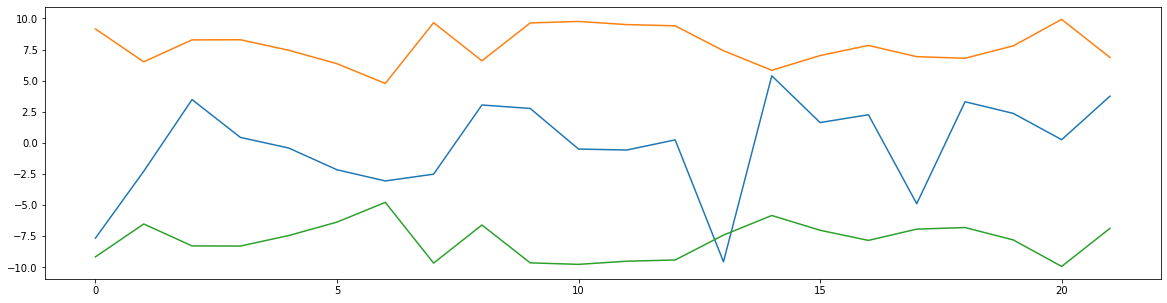

In [ ]:
mean = np.array(stats['mean'])
positive = np.array(stats['std'])
negative = np.negative(stats['std'])
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(5)

ax.plot([x for x in range(22)], mean)
ax.plot([x for x in range(22)], positive)
ax.plot([x for x in range(22)], negative)




In [ ]:
stats.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


0      -7.654239
1      -2.279437
2       3.481077
3       0.441122
4      -0.412002
          ...   
125    -1.844826
126    -1.833159
127     1.905186
mean   -0.210183
std     7.808614
Length: 130, dtype: float32

In [ ]:
stats2 = stats.set_index('ids')
stats3 = stats2.T
stats3

ids,fm0,fm1,fm2,fm3,fm4,fm5,fm6,fm7,fm8,fm9,...,am1,am2,am3,am4,am5,am6,am7,am8,am9,am10
0,-14.795782,-7.226787,-2.505748,-4.386611,-0.877882,-29.592857,-14.021227,-6.350094,0.443083,-0.602849,...,-12.345855,-14.547077,-1.473675,5.856646,0.129971,1.923909,-10.731566,-6.823734,-24.143623,4.281824
1,-11.947716,4.367860,-5.219619,2.115524,-1.339418,-15.858122,-3.258181,-9.760777,-2.664476,-0.323343,...,1.176102,9.304303,-8.050777,-6.245002,-6.045691,2.099400,-8.164140,5.599598,2.591741,1.624998
2,8.047822,12.853249,-12.280242,4.459554,-0.250670,7.868086,-4.357509,18.506094,-7.623561,2.970940,...,-3.208418,6.271921,16.243189,7.478319,-2.774672,0.904106,-1.618546,17.366993,8.240919,2.111582
3,9.558630,-25.384727,-3.395528,6.331384,4.854614,3.219487,8.880535,6.576551,0.570617,8.636977,...,-1.236889,-1.101929,11.646243,-2.592309,-2.601762,-15.615441,0.104764,0.923692,1.235663,-4.712379
4,-1.853710,-1.668204,13.362095,-12.271301,-9.407674,-8.890918,-1.387083,-3.697433,9.924716,-9.047282,...,13.312922,0.051979,-4.829734,-3.912918,-2.274196,4.802089,2.767992,1.251807,-0.359401,10.866202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-15.014729,-8.995099,-7.188708,-0.093345,-3.685283,-13.829837,3.704531,-10.253342,-5.420767,3.075157,...,-3.437087,8.482756,3.468423,-1.206729,8.155047,-3.389784,0.599426,-1.771266,-5.374383,0.789668
126,-6.442639,0.768094,4.559099,-0.789249,-7.982797,-11.912501,-9.805351,-4.377699,8.575545,2.677382,...,0.637171,-3.196998,10.172579,-3.601333,-9.354269,4.678353,-8.042078,12.461349,-4.752342,1.187557
127,-8.524030,-14.473238,8.828068,4.020247,-6.027159,19.490715,16.876696,2.527116,1.788113,-1.653022,...,1.262355,5.711911,-10.755740,-3.930387,-6.021528,-0.593231,3.779181,6.019522,7.723045,2.398520
mean,-7.654239,-2.279437,3.481077,0.441122,-0.412002,-2.158298,-3.055948,-2.512051,3.045613,2.766239,...,0.241931,-9.551316,5.390043,1.632959,2.262951,-4.885396,3.306908,2.368288,0.257937,3.756072


In [ ]:
sns.relplot(x = stats3.index, y = 'mean', data = stats3, kind= 'line', ci= 'sd')

ValueError: ignored

In [ ]:
stats3.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
          120,    121,    122,    123,    124,    125,    126,    127, 'mean',
        'std'],
      dtype='object', length=130)

In [ ]:
s = pd.Series(['feature_'+ str(x) for x in range(128)])
stats3 = stats3.set_index([s])
stats3

ids,fm0,fm1,fm2,fm3,fm4,fm5,fm6,fm7,fm8,fm9,...,am1,am2,am3,am4,am5,am6,am7,am8,am9,am10
feature_0,-14.795782,-7.226787,-2.505748,-4.386611,-0.877882,-29.592857,-14.021227,-6.350094,0.443083,-0.602849,...,-12.345855,-14.547077,-1.473675,5.856646,0.129971,1.923909,-10.731566,-6.823734,-24.143623,4.281824
feature_1,-11.947716,4.367860,-5.219619,2.115524,-1.339418,-15.858122,-3.258181,-9.760777,-2.664476,-0.323343,...,1.176102,9.304303,-8.050777,-6.245002,-6.045691,2.099400,-8.164140,5.599598,2.591741,1.624998
feature_2,8.047822,12.853249,-12.280242,4.459554,-0.250670,7.868086,-4.357509,18.506094,-7.623561,2.970940,...,-3.208418,6.271921,16.243189,7.478319,-2.774672,0.904106,-1.618546,17.366993,8.240919,2.111582
feature_3,9.558630,-25.384727,-3.395528,6.331384,4.854614,3.219487,8.880535,6.576551,0.570617,8.636977,...,-1.236889,-1.101929,11.646243,-2.592309,-2.601762,-15.615441,0.104764,0.923692,1.235663,-4.712379
feature_4,-1.853710,-1.668204,13.362095,-12.271301,-9.407674,-8.890918,-1.387083,-3.697433,9.924716,-9.047282,...,13.312922,0.051979,-4.829734,-3.912918,-2.274196,4.802089,2.767992,1.251807,-0.359401,10.866202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_123,-10.840456,11.370034,5.621507,1.755874,4.240277,-13.175158,-1.379543,-1.138168,0.469336,-4.402750,...,-8.865695,-2.087730,-5.760031,-3.477257,-0.066836,-5.349413,-0.644168,7.867125,-4.215731,7.635879
feature_124,-0.045677,10.248044,7.873076,0.388554,-2.307746,15.945800,8.148353,5.472628,7.173205,-5.762714,...,7.585567,7.799247,-5.388248,1.273514,-1.347938,3.059136,4.695436,4.853006,1.013948,11.928339
feature_125,-15.014729,-8.995099,-7.188708,-0.093345,-3.685283,-13.829837,3.704531,-10.253342,-5.420767,3.075157,...,-3.437087,8.482756,3.468423,-1.206729,8.155047,-3.389784,0.599426,-1.771266,-5.374383,0.789668
feature_126,-6.442639,0.768094,4.559099,-0.789249,-7.982797,-11.912501,-9.805351,-4.377699,8.575545,2.677382,...,0.637171,-3.196998,10.172579,-3.601333,-9.354269,4.678353,-8.042078,12.461349,-4.752342,1.187557


In [ ]:
stats3['mean'] = stats3.mean(axis=1)
stats3['std'] = stats3.std(axis=1)
stats3

ids,fm0,fm1,fm2,fm3,fm4,fm5,fm6,fm7,fm8,fm9,...,am3,am4,am5,am6,am7,am8,am9,am10,mean,std
feature_0,-14.795782,-7.226787,-2.505748,-4.386611,-0.877882,-29.592857,-14.021227,-6.350094,0.443083,-0.602849,...,-1.473675,5.856646,0.129971,1.923909,-10.731566,-6.823734,-24.143623,4.281824,-7.654239,8.946506
feature_1,-11.947716,4.367860,-5.219619,2.115524,-1.339418,-15.858122,-3.258181,-9.760777,-2.664476,-0.323343,...,-8.050777,-6.245002,-6.045691,2.099400,-8.164140,5.599598,2.591741,1.624998,-2.279437,6.364547
feature_2,8.047822,12.853249,-12.280242,4.459554,-0.250670,7.868086,-4.357509,18.506094,-7.623561,2.970940,...,16.243189,7.478319,-2.774672,0.904106,-1.618546,17.366993,8.240919,2.111582,3.481077,8.087003
feature_3,9.558630,-25.384727,-3.395528,6.331384,4.854614,3.219487,8.880535,6.576551,0.570617,8.636977,...,11.646243,-2.592309,-2.601762,-15.615441,0.104764,0.923692,1.235663,-4.712379,0.441122,8.096662
feature_4,-1.853710,-1.668204,13.362095,-12.271301,-9.407674,-8.890918,-1.387083,-3.697433,9.924716,-9.047282,...,-4.829734,-3.912918,-2.274196,4.802089,2.767992,1.251807,-0.359401,10.866202,-0.412002,7.273965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_123,-10.840456,11.370034,5.621507,1.755874,4.240277,-13.175158,-1.379543,-1.138168,0.469336,-4.402750,...,-5.760031,-3.477257,-0.066836,-5.349413,-0.644168,7.867125,-4.215731,7.635879,-0.804696,6.286859
feature_124,-0.045677,10.248044,7.873076,0.388554,-2.307746,15.945800,8.148353,5.472628,7.173205,-5.762714,...,-5.388248,1.273514,-1.347938,3.059136,4.695436,4.853006,1.013948,11.928339,3.916448,5.406305
feature_125,-15.014729,-8.995099,-7.188708,-0.093345,-3.685283,-13.829837,3.704531,-10.253342,-5.420767,3.075157,...,3.468423,-1.206729,8.155047,-3.389784,0.599426,-1.771266,-5.374383,0.789668,-1.844826,6.541382
feature_126,-6.442639,0.768094,4.559099,-0.789249,-7.982797,-11.912501,-9.805351,-4.377699,8.575545,2.677382,...,10.172579,-3.601333,-9.354269,4.678353,-8.042078,12.461349,-4.752342,1.187557,-1.833159,8.201706


In [ ]:
import seaborn as sns
sns.relplot(x = 'ids', y = 'mean', data = stats3, kind= 'line', ci = 'std')

ValueError: ignored

In [ ]:
df2 = stats2.mean(axis=0)
df2

0     -8.014960
1     -2.417893
2      3.136595
3      0.020141
4     -1.276112
         ...   
123   -0.962866
124    3.949743
125   -2.536394
126   -1.555254
127   -0.170657
Length: 128, dtype: float32

In [ ]:
stats[0].mean()
stats[0].std()

9.513554

In [ ]:
#@title Visualización del espacio latente
dropdown = 'Espacio_latente' #@param ["Espacio_latente", "cargar_espacio", "3rd option"]
fig, ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)

if dropdown == 'Espacio_latente':
  pca = PCA(n_components= 2)
  X_PCA = pca.fit_transform(all_tracks_latent)
  print('variance: ')
  print(pca.explained_variance_ratio_)
  counter = 0 
  cu = 0
  for key, value in zliders.items():
    #print(key,value)
    ax.scatter(X_PCA[counter: counter + value, 0], X_PCA[counter: counter + value, 1], cmap= 10, label = key)
    counter += value
    cu += 1
  for idx, id in enumerate(ids):
    ax.annotate(id,(X_PCA[idx][0], X_PCA[idx][1]+ 0.2))
  fig.add_axes(ax)
  plt.legend()
  plt.title('PCA')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.show()







if dropdown == 'cargar_espacio':
  print('Próximamente....')


In [ ]:
#@title Generación de Audios
referencia_1 = 'undefined' #@param []
referencia_2 = '-' #@param ['Interpolación lineal','Vecinos euclidaneos','-']

tecnicas = 'Vecinos euclidaneos' #@param ['Interpolación lineal','Vecinos euclidaneos']

In [ ]:
list(DATA_filt['id'])

In [ ]:
x = latent[0]
y = latent[1]
xx, yy = np. meshgrid(x, y)

In [ ]:
from scipy import interpolate
import numpy as np
import matplotlib. pyplot as plt
x = np. arange(-10.01, 10.01, 0.50)
y = np. arange(-10.01, 10.01, 0.50)
xx, yy = np. meshgrid(x, y)
z = np. cos(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='quintic')
f

In [ ]:
from google.colab import drive
#drive.mount('drive')
DATA_filt['data'].to_pickle('data.pkl')
!cp data.pkl "drive/My Drive/"

In [ ]:
#@title Descarga de materiales
!zip -r /content/model_vae.zip /content/model_vae

modelo = True #@param {type:"boolean"}
espacio_latente = True #@param {type:"boolean"}
boolean_checkbox = True #@param {type:"boolean"}

if modelo == True:
  files.download('/content/model_vae.zip')

'am_4.wav'

In [ ]:
from google.colab import files
!zip -r /content/model_vae.zip /content/model_vae


  adding: content/model_vae/ (stored 0%)
  adding: content/model_vae/keras_metadata.pb (deflated 95%)
  adding: content/model_vae/assets/ (stored 0%)
  adding: content/model_vae/saved_model.pb (deflated 90%)
  adding: content/model_vae/variables/ (stored 0%)
  adding: content/model_vae/variables/variables.index (deflated 61%)
  adding: content/model_vae/variables/variables.data-00000-of-00001 (deflated 9%)


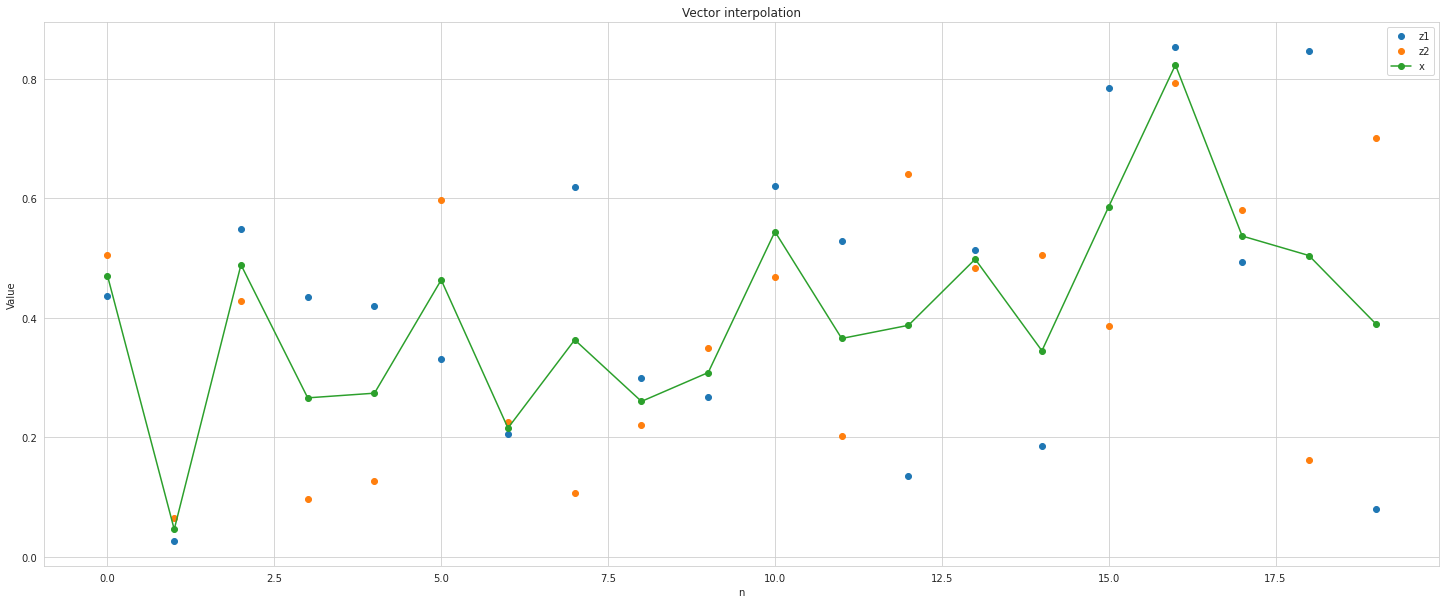

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig , ax = plt.subplots()
fig.set_figwidth(25)
fig.set_figheight(10)
np.random.seed(2)
x = [np.random.random(20),np.random.random(20)]

x_mu= np.mean(x, axis = 1)[...,np.newaxis]
s_fft = np.std(x, axis = 1)[...,np.newaxis]
Xmu_ = x - x_mu/s_fft

z = x[0] + x[1] 
z = 0.5 * z
d = {'x': x[0], 'y': x[1], 'z': z}
df = pd.DataFrame(d)
#print(df)
ax.plot(df.index,x[0], marker = 'o',linestyle = "None", label = 'z1')
ax.plot(df.index,x[1], marker = 'o', linestyle = "None", label = 'z2')
ax.plot(df.index,z, marker = 'o', label = 'x')
ax.set_title('Vector interpolation')
ax.set_xlabel('n')
ax.set_ylabel('Value')
ax.legend()
plt.show()


